# PRA Risk Summaries & Evasiveness Detector — **Lazy-Load + Cache-Warm**

*Designed to be run in Google Colab*. Generates PRA risk-aligned summaries and flags banker evasiveness.

In [1]:
# Light env & system check
import os, sys, platform, warnings, re
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

os.environ.setdefault("TRANSFORMERS_NO_TF", "1")
os.environ.setdefault("TRANSFORMERS_NO_FLAX", "1")
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
os.environ.setdefault("HF_HUB_ENABLE_HF_TRANSFER", "1")
os.environ.setdefault("HF_HUB_DISABLE_TELEMETRY", "1")

print("Python:", sys.version.split()[0], "| OS:", platform.platform(), "| Arch:", platform.machine())

try:
    import torch
    print("Torch:", torch.__version__, "| CUDA built:", torch.cuda.is_built(), "| CUDA avail:", torch.cuda.is_available())
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
except Exception as e:
    print("Torch not available:", e); DEVICE="cpu"

SEED=42; np.random.seed(SEED)

Python: 3.12.11 | OS: Linux-6.1.123+-x86_64-with-glibc2.35 | Arch: x86_64
Torch not available: module 'torch.cuda' has no attribute 'is_built'


In [19]:
from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [31]:
# Config
DATA_DIR = Path("/content/drive/MyDrive/Data/Processed") # Updated path
JPM_PATH = DATA_DIR / "jpm" / "all_jpm_2023_2025.csv" # Updated path
HSBC_PATH = DATA_DIR / "hsbc" / "all_hsbc_2023_2025.csv" # Updated path

RAG_DIR = Path("/content/drive/MyDrive/Data/RAG") # Updated path
PRA_PATHS = [RAG_DIR / "PRA_risk_categories.csv"] # Updated path

EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"
SUMM_MODEL_ID  = "sshleifer/distilbart-cnn-12-6"

SIMILARITY_LOW = 0.38
HEDGE_MIN_COUNT = 2
VERBOSITY_RATIO_HIGH = 6.0
READABILITY_SIMPLE = 8.0
EVASION_SCORE_FLAG = 0.65

SUMMARY_TARGET_WORDS = 120

In [7]:

# Warm model cache
from huggingface_hub import snapshot_download
def warm_cache(model_id: str):
    path = snapshot_download(repo_id=model_id, local_files_only=False)
    print(f"Cached -> {path}")
try:
    warm_cache(EMBED_MODEL_ID); warm_cache(SUMM_MODEL_ID)
except Exception as e:
    print("Cache warm skipped:", e)


.gitattributes: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

onnx/model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

onnx/model_O1.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

onnx/model_O2.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

onnx/model_O3.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

onnx/model_O4.onnx:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

onnx/model_qint8_arm64.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

onnx/model_quint8_avx2.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

openvino/openvino_model.bin:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

openvino_model.xml: 0.00B [00:00, ?B/s]

openvino/openvino_model_qint8_quantized.(…):   0%|          | 0.00/22.9M [00:00<?, ?B/s]

openvino_model_qint8_quantized.xml: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/91.0M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Cached -> /root/.cache/huggingface/hub/models--sentence-transformers--all-MiniLM-L6-v2/snapshots/c9745ed1d9f207416be6d2e6f8de32d1f16199bf


.gitattributes:   0%|          | 0.00/391 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

flax_model.msgpack:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Cached -> /root/.cache/huggingface/hub/models--sshleifer--distilbart-cnn-12-6/snapshots/a4f8f3ea906ed274767e9906dbaede7531d660ff


In [32]:

# Helpers
HEDGE_PHRASES = [
    "i think","we think","i believe","we believe","we feel","i feel",
    "sort of","kind of","a bit","a little","roughly","approximately","around","more or less","to some extent","somewhat",
    "we don't break out","we do not break out","we don't disclose","we do not disclose",
    "we won't comment","we will not comment","not going to comment",
    "too early to say","too soon to say","too soon to tell",
    "we'll have to see","we will have to see","we'll come back","we will come back",
    "as we've said before","as we said before","as previously mentioned","as mentioned",
    "let me step back","take a step back","the way i would frame","i would frame it",
    "i'm not sure","we're not sure","it's complicated","it's complex","moving parts",
    "as you know","as you can appreciate","that's a great question","good question",
    "let me answer a different","let me start somewhere else"
]

def normalize_text(s: str) -> str:
    return re.sub(r"\s+", " ", (s or "")).strip()

def count_hedges(text: str) -> int:
    t = " " + (text or "").lower() + " "
    return sum(1 for p in HEDGE_PHRASES if f" {p} " in t)

def fk_grade(text: str) -> float:
    try:
        import textstat
        return textstat.flesch_kincaid_grade(text or "")
    except Exception:
        import math; return math.nan


In [33]:

# Lazy loaders
import functools
def _best_device():
    try:
        import torch
        if torch.backends.mps.is_available() and torch.backends.mps.is_built(): return "mps"
        if torch.cuda.is_available(): return "cuda"
    except Exception: pass
    return "cpu"

@functools.lru_cache(maxsize=1)
def get_embedder(model_id=EMBED_MODEL_ID):
    from sentence_transformers import SentenceTransformer
    dev = _best_device()
    return SentenceTransformer(model_id, device=dev), dev

@functools.lru_cache(maxsize=1)
def get_summarizer(model_id=SUMM_MODEL_ID):
    from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
    import torch
    tok = AutoTokenizer.from_pretrained(model_id)
    mod = AutoModelForSeq2SeqLM.from_pretrained(model_id)
    dev = _best_device()
    try: mod = mod.to(dev)
    except Exception: pass
    return tok, mod, dev


In [34]:
# LoaderAgent
class LoaderAgent:
    def __init__(self, jpm_path: Path, hsbc_path: Path):
        self.jpm_path = jpm_path; self.hsbc_path = hsbc_path
    def load_df(self) -> pd.DataFrame:
        frames = []
        if self.jpm_path.exists(): j = pd.read_csv(self.jpm_path); j["bank"]="JPM"; frames.append(j)
        if self.hsbc_path.exists(): h = pd.read_csv(self.hsbc_path); h["bank"]="HSBC"; frames.append(h)
        assert frames, "No input CSVs found."
        df = pd.concat(frames, ignore_index=True)
        for c in ["content","speaker_name","role","company","section","source_pdf"]:
            if c in df.columns: df[c] = df[c].astype(str).map(normalize_text)
        if "year" in df.columns: df["year"] = pd.to_numeric(df["year"], errors="coerce")
        if "quarter" in df.columns:
            df["quarter"] = df["quarter"].astype(str).str.upper().str.replace(" ", "", regex=False)
            df["quarter"] = df["quarter"].str.replace("Q0","Q4", regex=False)
        if "section" in df.columns:
            df = df[df["section"].str.contains("QUESTION|Q&A", case=False, na=False) | (df["answer_number"].notna())]
        if "is_pleasantry" in df.columns: df = df[df["is_pleasantry"] != True]
        return df.dropna(subset=["content"]).reset_index(drop=True)

qa_df = LoaderAgent(JPM_PATH, HSBC_PATH).load_df()
print("Loaded rows:", len(qa_df)); qa_df.head(3)


Loaded rows: 1017


,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf,bank
0,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,JPM
1,qa,1.0,1.0,Steven Chubak,analyst,Wolfe Research LLC,Got it. And just in terms of appetite for the ...,2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,JPM
2,qa,1.0,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Oh, yeah.",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...,JPM


In [24]:
import os

def find_files_in_drive(filename_patterns):
    found_files = []
    drive_path = '/content/drive/MyDrive/Data' # Starting search from MyDrive
    if not os.path.exists(drive_path):
        print("Google Drive not mounted at /content/drive/MyDrive/Data")
        return []

    print(f"Searching for files matching {filename_patterns} in {drive_path}...")
    for root, _, files in os.walk(drive_path):
        for file in files:
            if any(pattern.lower() in file.lower() for pattern in filename_patterns):
                found_files.append(os.path.join(root, file))
    return found_files

# Specify the filenames you are looking for
filenames_to_find = ['/Processed/hsbc/all_hsbc_2023_2025.csv', '/Processed/jpm/all_jpm_2023_2025.csv', '/Processed/RAG/PRA_risk_categories.csv'] # Added PRA categories file
found_paths = find_files_in_drive(filenames_to_find)

if found_paths:
    print("\nFound files:")
    for path in found_paths:
        print(path)
    print("\nCopy the correct paths from the list above and update the config cell (513de5cb).")
else:
    print("\nNo matching files found in your mounted Google Drive.")
    print("Please ensure the files are in your Google Drive and it is correctly mounted.")

Searching for files matching ['/Processed/hsbc/all_hsbc_2023_2025.csv', '/Processed/jpm/all_jpm_2023_2025.csv', '/Processed/RAG/PRA_risk_categories.csv'] in /content/drive/MyDrive/Data...

No matching files found in your mounted Google Drive.
Please ensure the files are in your Google Drive and it is correctly mounted.


In [36]:
# PRA categories & mapper
def load_pra_categories(paths):
    for p in paths:
        if p.exists():
            cat = pd.read_csv(p)
            cols = {c.lower().strip(): c for c in cat.columns}
            cat = cat.rename(columns={cols.get("category", cat.columns[0]): "category"})
            if "description" not in [c.lower() for c in cat.columns]: cat["description"]=""
            return cat[["category","description"]].dropna().reset_index(drop=True)
    raise FileNotFoundError("PRA categories file not found.")

pra_df = load_pra_categories(PRA_PATHS)
embedder, EMBED_DEV = get_embedder()
from sentence_transformers import util as st_util
pra_texts = (pra_df["category"] + ". " + pra_df["description"].fillna("")).tolist()
pra_embs = embedder.encode(pra_texts, convert_to_tensor=True, normalize_embeddings=True)

KEYWORDS = {
    "Credit risk": ["credit","NPL","non-performing","loan loss","default","provision","counterparty"],
    "Market risk": ["trading","VaR","volatility","rates","FX","equities","derivatives","market risk"],
    "Liquidity risk": ["liquidity","LCR","NSFR","funding","deposits","outflows","liquidity coverage"],
    "Capital risk": ["capital","CET1","RWA","leverage ratio","buffers","Pillar 2","dividends","buybacks"],
    "Operational risk": ["operational","ops","cyber","fraud","conduct","model risk","technology"],
    "IRRBB": ["interest rate risk in the banking book","IRRBB","ALM","duration","asset-liability"],
    "Climate & ESG": ["climate","ESG","sustainability","transition risk","physical risk","emissions"],
    "Model risk": ["model risk","validation","challenge","backtesting","stress test"],
    "Conduct risk": ["conduct","mis-selling","complaints","whistleblowing","FCA"]
}
kw2cat = {kw.lower(): cat for cat, kws in KEYWORDS.items() for kw in kws}

def map_to_pra_categories(text: str, top_k: int = 2):
    text_norm = (text or "").lower()
    hits = {kw2cat[kw] for kw in kw2cat if f" {kw} " in f" {text_norm} "}
    q_emb = embedder.encode([text or ""], convert_to_tensor=True, normalize_embeddings=True)
    sims = st_util.cos_sim(q_emb, pra_embs).cpu().numpy().ravel()
    nn_idx = sims.argsort()[::-1][:top_k]
    nn_cats = [pra_df.iloc[i]["category"] for i in nn_idx]
    cats = list(dict.fromkeys(list(hits) + nn_cats))
    return cats, float(sims[nn_idx[0]])


In [37]:
# Build Q/A pairs
import tqdm
def build_pairs(df: pd.DataFrame):
    def is_analyst(role, speaker):
        role = (role or "").lower(); speaker = (speaker or "").lower()
        return ("analyst" in role) or ("analyst" in speaker)
    def is_banker(role, speaker):
        role = (role or "").lower(); speaker = (speaker or "").lower()
        mgmt = ["chief","ceo","cfo","coo","treasurer","head","president","vice","managing director"]
        return any(m in role for m in mgmt) or ("jpmorgan" in speaker) or ("hsbc" in speaker) or ("executive" in role)

    df = df.copy()
    df["is_analyst_row"] = df.apply(lambda r: is_analyst(r.get("role",""), r.get("speaker_name","")), axis=1)
    df["is_banker_row"]  = df.apply(lambda r: is_banker(r.get("role",""), r.get("speaker_name","")), axis=1)

    if "question_number" not in df.columns:
        df["question_number"] = df.groupby(["bank","year","quarter"]).cumcount()+1

    pairs = []
    gcols = ["bank","year","quarter","question_number"]
    for key, g in tqdm.tqdm(df.groupby(gcols, dropna=False), desc="Building Q/A pairs"):
        g = g.sort_index()
        qtxt = " ".join(g.loc[g["is_analyst_row"], "content"].tolist())
        atxt = " ".join(g.loc[g["is_banker_row"], "content"].tolist())
        if not qtxt and not atxt: continue
        # Batching for category mapping will be handled within the function if needed,
        # but the primary bottleneck is usually the Q/A encoding.
        cats, cat_sim = map_to_pra_categories((qtxt or "") + " " + (atxt or ""))
        pairs.append({
            "bank": key[0], "year": key[1], "quarter": key[2], "question_number": key[3],
            "question_text": normalize_text(qtxt), "answer_text": normalize_text(atxt),
            "pra_categories": cats, "pra_sim": cat_sim
        })
    pairs_df = pd.DataFrame(pairs)
    pairs_df = pairs_df[(pairs_df["question_text"].str.len()>0) | (pairs_df["answer_text"].str.len()>0)].reset_index(drop=True)
    print("Pairs built:", len(pairs_df))
    return pairs_df

pairs_df = build_pairs(qa_df); pairs_df.head(3)

Building Q/A pairs: 100%|██████████| 232/232 [00:19<00:00, 11.71it/s]

Pairs built: 222


,bank,year,quarter,question_number,question_text,answer_text,pra_categories,pra_sim
0,JPM,2023,Q1,1.0,Got it. And just in terms of appetite for the ...,"Well, I think you were already kind of complet...","[Capital risk, Risk management, Market risk]",0.306777
1,JPM,2023,Q1,2.0,,"Yeah, sure. So let me just summarize the drive...","[Market risk, Liquidity]",0.340181
2,JPM,2023,Q1,3.0,Okay. Thank you very much. Operator: Thank you...,"Well first of all, I don't quite believe it. S...","[Market risk, Liquidity]",0.286471


In [38]:
# Evasion scoring
from sentence_transformers import util as st_util
import tqdm

def compute_evasion(pairs_df: pd.DataFrame, batch_size=32):
    emb, _ = get_embedder()
    # Batch processing for embeddings
    q_embs = emb.encode(pairs_df["question_text"].tolist(), convert_to_tensor=True, normalize_embeddings=True, show_progress_bar=True, batch_size=batch_size)
    a_embs = emb.encode(pairs_df["answer_text"].tolist(), convert_to_tensor=True, normalize_embeddings=True, show_progress_bar=True, batch_size=batch_size)
    cos_sims = st_util.cos_sim(q_embs, a_embs).diagonal().cpu().numpy()

    def safe_len(x): return 0 if x is None else len(str(x))

    def evasion_score(row, sim):
        q = row["question_text"]; a = row["answer_text"]
        if not a: return 1.0
        hedges = count_hedges(a)
        ratio = (safe_len(a)+1)/(safe_len(q)+1)
        grade = fk_grade(a)
        sim_comp   = max(0.0, min(1.0, (SIMILARITY_LOW - sim) / SIMILARITY_LOW))
        hedge_comp = min(1.0, hedges / max(HEDGE_MIN_COUNT, 1))
        ratio_comp = min(1.0, max(0.0, (ratio - 1.5) / (VERBOSITY_RATIO_HIGH - 1.5)))
        grade_comp = min(1.0, max(0.0, (grade - READABILITY_SIMPLE)/10.0))
        return float(round(0.45*sim_comp + 0.25*hedge_comp + 0.20*ratio_comp + 0.10*grade_comp, 4))

    out = pairs_df.copy()
    out["qa_similarity"] = cos_sims
    out["hedge_count"] = out["answer_text"].map(count_hedges)
    out["ans_to_q_len_ratio"] = (out["answer_text"].str.len()+1)/(out["question_text"].str.len()+1)
    out["fk_grade_answer"] = out["answer_text"].map(fk_grade)
    # Add progress bar for evasion score calculation
    out["evasion_score"] = [evasion_score(r, s) for r, s in tqdm.tqdm(zip(out.to_dict("records"), cos_sims), total=len(out), desc="Computing evasion scores")]
    out["evasive_flag"] = out["evasion_score"] >= EVASION_SCORE_FLAG
    return out

pairs_df = compute_evasion(pairs_df)
pairs_df.sort_values("evasion_score", ascending=False).head(5)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing evasion scores: 100%|██████████| 222/222 [00:00<00:00, 5059.94it/s]


,bank,year,quarter,question_number,question_text,answer_text,pra_categories,pra_sim,qa_similarity,hedge_count,ans_to_q_len_ratio,fk_grade_answer,evasion_score,evasive_flag
63,JPM,2023,Q3,12.0,,"Yeah. So, Erika, I think the simple answer to ...","[Liquidity risk, Market risk, Liquidity]",0.333196,-0.014034,7,3506.0,NaN,0.9,True
60,JPM,2023,Q3,8.0,,"Yeah, sure. So on loan growth, the story is pr...","[Market risk, Credit risk, Liquidity]",0.202114,-0.013906,4,2792.0,NaN,0.9,True
112,JPM,2024,Q1,21.0,Alright. Thank you.,"Right. Okay, Charlie. There's a lot in there. ...","[Capital risk, Market risk, Liquidity]",0.323954,-0.021328,2,122.2,NaN,0.9,True
106,JPM,2024,Q1,15.0,Awesome. Thank you.,"Sure. So, I think the first thing to say which...","[Liquidity, Risk management]",0.258086,-0.086027,3,96.2,NaN,0.9,True
191,JPM,2025,Q2,2.0,,"I mean, we've talked about that a little bit o...","[Capital risk, Capital adequacy, Liquidity]",0.330310,-0.001122,2,1610.0,NaN,0.9,True


In [39]:

# Summaries
def chunk_text(s: str, max_chars=2500):
    s = normalize_text(s or "")
    if len(s) <= max_chars: return [s]
    parts = re.split(r'(?<=[\.!?])\s+', s); chunks, buf = [], ""
    for p in parts:
        if len(buf) + len(p) + 1 < max_chars: buf += (" " if buf else "") + p
        else: chunks.append(buf); buf = p
    if buf: chunks.append(buf); return chunks

def summarise_text(text: str, max_new_tokens=200):
    import torch
    tok, mod, dev = get_summarizer()
    outs = []
    for ch in chunk_text(text):
        inputs = tok(ch, return_tensors="pt", truncation=True, max_length=1024).to(dev)
        with torch.no_grad():
            out = mod.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False)
        outs.append(tok.decode(out[0], skip_special_tokens=True).strip())
    return " ".join(outs)

def build_summaries(pairs: pd.DataFrame, by_cols=("bank","year","quarter")):
    rows = []
    for key, g in pairs.groupby(list(by_cols)):
        gg = g.explode("pra_categories").dropna(subset=["pra_categories"])
        for cat, gcat in gg.groupby("pra_categories"):
            text = " ".join(gcat["answer_text"].tolist())
            summ = summarise_text(text, max_new_tokens=200) if text.strip() else ""
            if len(summ.split()) > SUMMARY_TARGET_WORDS*1.5:
                summ = summarise_text(summ, max_new_tokens=120)
            rows.append({**{c:k for c,k in zip(by_cols,key)},
                         "pra_category": cat, "summary": summ,
                         "n_pairs": len(gcat),
                         "median_evasion": float(np.median(gcat["evasion_score"]))})
    return pd.DataFrame(rows).sort_values(list(by_cols)+["pra_category"]).reset_index(drop=True)

summ_df = build_summaries(pairs_df, by_cols=("bank","year","quarter"))
summ_df.head(3)


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

,bank,year,quarter,pra_category,summary,n_pairs,median_evasion
0,JPM,2023,Q1,Capital adequacy,The market would take loans at much lower capi...,3,0.6006
1,JPM,2023,Q1,Capital risk,"We expect higher capital from Basel IV, effect...",5,0.6191
2,JPM,2023,Q1,Credit risk,The large majority of our commercial real esta...,13,0.7327


In [40]:

# Save & peek
from datetime import datetime
OUT_DIR = Path("./outputs"); OUT_DIR.mkdir(parents=True, exist_ok=True)
ts = datetime.now().strftime("%Y%m%d-%H%M")
pairs_path = OUT_DIR / f"qa_pairs_with_evasion_{ts}.csv"
summ_path  = OUT_DIR / f"pra_category_summaries_{ts}.csv"
pairs_df.to_csv(pairs_path, index=False); summ_df.to_csv(summ_path, index=False)
print("Saved:", pairs_path, "|", summ_path)

cols = ["bank","year","quarter","question_number","pra_categories","qa_similarity",
        "hedge_count","ans_to_q_len_ratio","fk_grade_answer","evasion_score","evasive_flag",
        "question_text","answer_text"]
pairs_df.sort_values("evasion_score", ascending=False)[cols].head(10)


Saved: outputs/qa_pairs_with_evasion_20250922-0636.csv | outputs/pra_category_summaries_20250922-0636.csv


,bank,year,quarter,question_number,pra_categories,qa_similarity,hedge_count,ans_to_q_len_ratio,fk_grade_answer,evasion_score,evasive_flag,question_text,answer_text
63,JPM,2023,Q3,12.0,"[Liquidity risk, Market risk, Liquidity]",-0.014034,7,3506.000000,NaN,0.9,True,,"Yeah. So, Erika, I think the simple answer to ..."
60,JPM,2023,Q3,8.0,"[Market risk, Credit risk, Liquidity]",-0.013906,4,2792.000000,NaN,0.9,True,,"Yeah, sure. So on loan growth, the story is pr..."
112,JPM,2024,Q1,21.0,"[Capital risk, Market risk, Liquidity]",-0.021328,2,122.200000,NaN,0.9,True,Alright. Thank you.,"Right. Okay, Charlie. There's a lot in there. ..."
106,JPM,2024,Q1,15.0,"[Liquidity, Risk management]",-0.086027,3,96.200000,NaN,0.9,True,Awesome. Thank you.,"Sure. So, I think the first thing to say which..."
191,JPM,2025,Q2,2.0,"[Capital risk, Capital adequacy, Liquidity]",-0.001122,2,1610.000000,NaN,0.9,True,,"I mean, we've talked about that a little bit o..."
210,JPM,2025,Q2,21.0,"[Liquidity risk, Governance, Operational risk]",-0.042710,4,70.939394,NaN,0.9,True,All right. Thanks for the color. All right. Th...,"Yeah, it's a good question. You may recall, I ..."
201,JPM,2025,Q2,12.0,"[Market risk, Liquidity]",-0.002837,6,80.153846,NaN,0.9,True,Got it. Great. Thank you. Got it. Great. Thank...,"Yeah, sure. So, I think what you're referring ..."
155,JPM,2024,Q4,2.0,"[Operational risk, Liquidity, Market risk]",-0.074371,7,974.250000,NaN,0.9,True,nan nan,Sure. The truth is – and I guess this is a goo...
131,JPM,2024,Q3,1.0,"[Market risk, Credit risk]",-0.027557,5,108.760000,NaN,0.9,True,All right. Thanks a lot.,"Yeah. Sure, Jim. I'll try to answer both quest..."
116,JPM,2024,Q2,4.0,"[Capital risk, Liquidity, Risk management]",-0.021650,4,1288.000000,NaN,0.9,True,,"Sure. Yeah. I mean, I would direct you to read..."


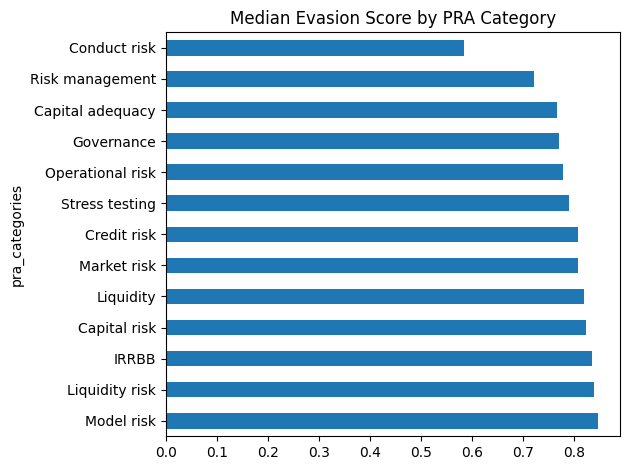

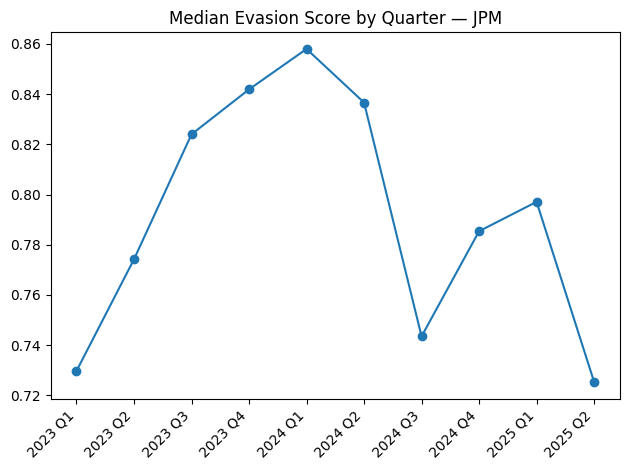

In [41]:

# Visuals
gg = pairs_df.explode("pra_categories").dropna(subset=["pra_categories"])
if not gg.empty:
    med = gg.groupby("pra_categories")["evasion_score"].median().sort_values(ascending=False)
    plt.figure(); med.plot(kind="barh"); plt.title("Median Evasion Score by PRA Category"); plt.tight_layout(); plt.show()

qmed = pairs_df.groupby(["bank","year","quarter"])["evasion_score"].median().reset_index()
if not qmed.empty:
    qmed["q_label"] = qmed["year"].astype(str) + " " + qmed["quarter"].astype(str)
    for bank, g in qmed.groupby("bank"):
        plt.figure(); plt.plot(g["q_label"], g["evasion_score"], marker="o")
        plt.title(f"Median Evasion Score by Quarter — {bank}")
        plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


 ## Visualise (median) evasion score by PRA category over time

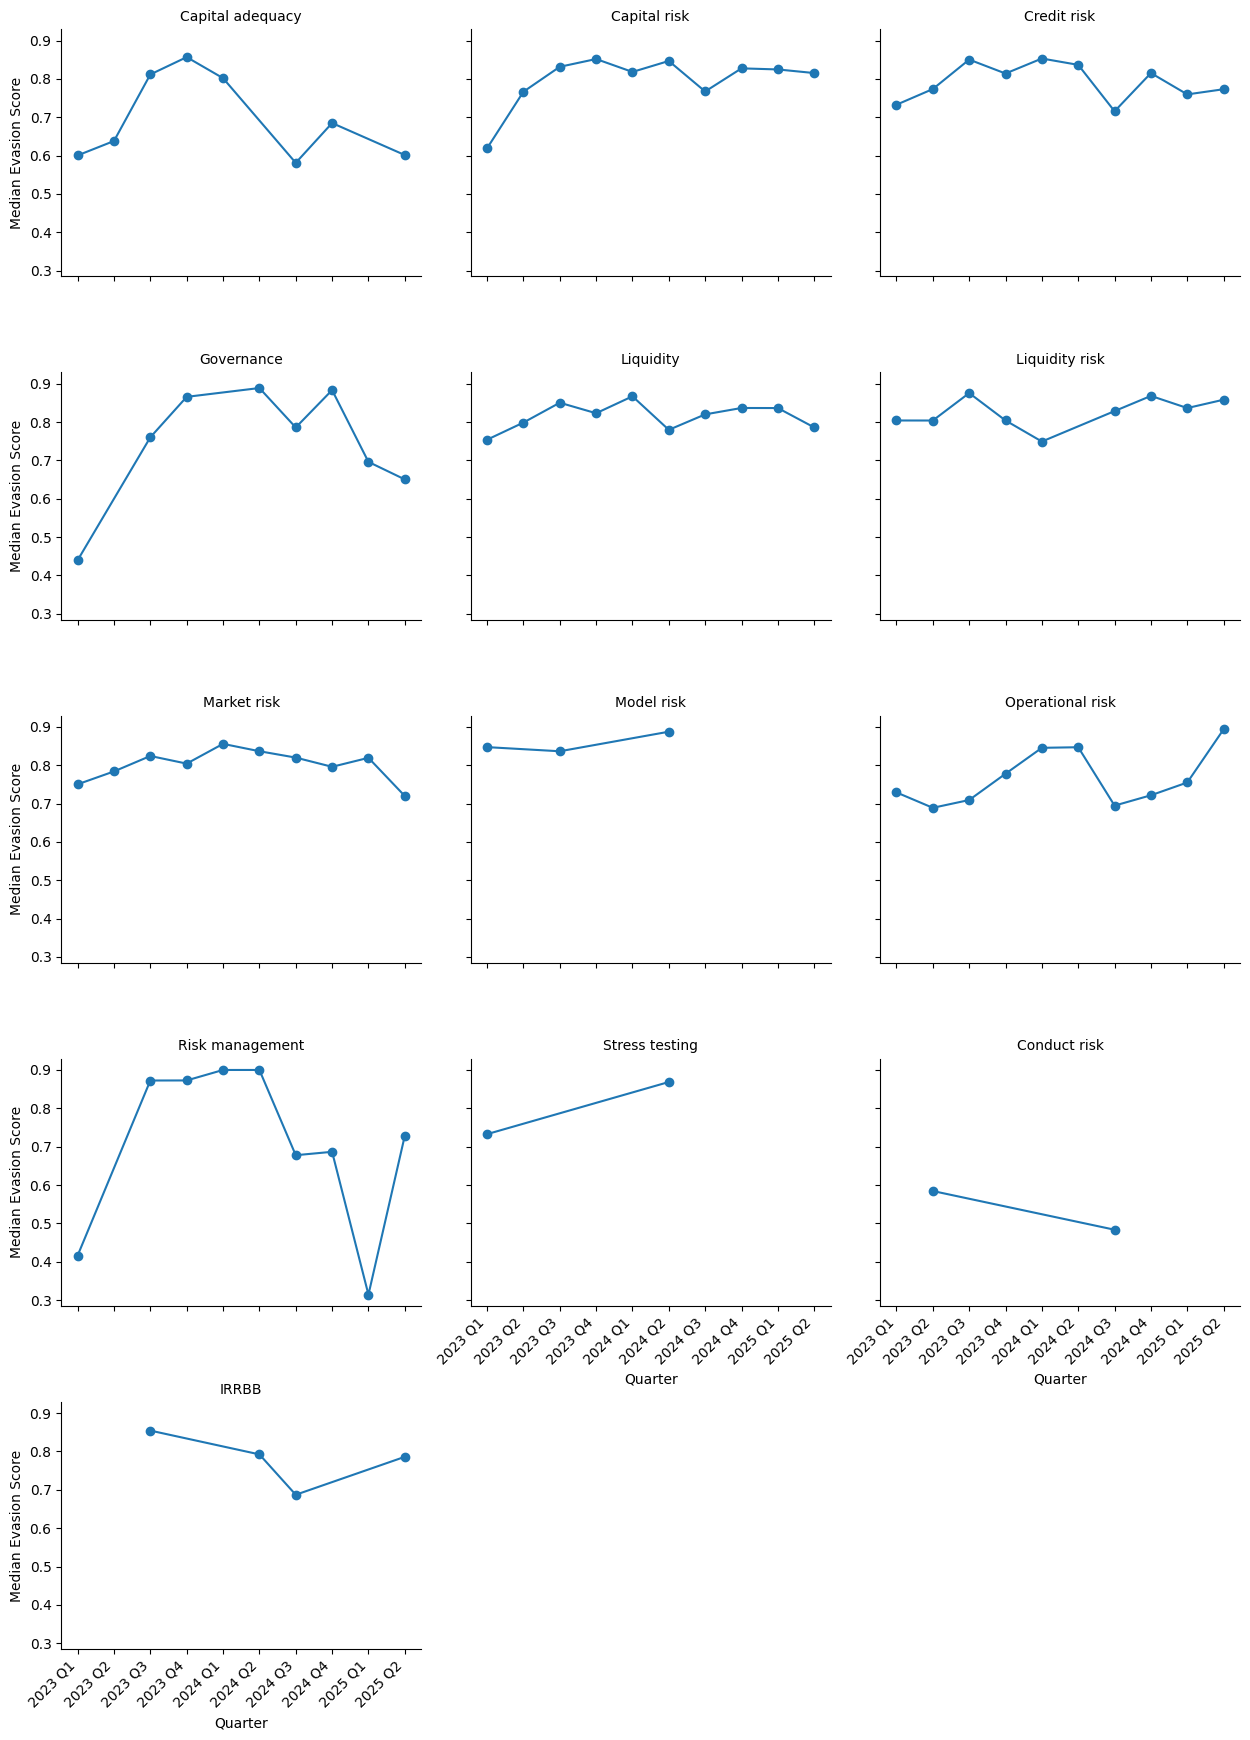

In [46]:
# Faceted plot of median evasion score by PRA category over time
import seaborn as sns
import matplotlib.pyplot as plt

# Explode the pairs_df to have one row per PRA category per Q&A pair
gg = pairs_df.explode("pra_categories").dropna(subset=["pra_categories"])

if not gg.empty:
    # Group by bank, year, quarter, and PRA category to calculate median evasion score
    cat_q_med = gg.groupby(["bank", "year", "quarter", "pra_categories"])["evasion_score"].median().reset_index()

    # Ensure the data is sorted by year and quarter for correct plotting order
    cat_q_med = cat_q_med.sort_values(by=["year", "quarter"])

    # Create a combined quarter label for plotting
    cat_q_med["q_label"] = cat_q_med["year"].astype(str) + " " + cat_q_med["quarter"].astype(str)

    # Create a numerical representation of the quarter for plotting order
    # Assuming quarter is Q1, Q2, Q3, Q4
    quarter_map = {"Q1": 0.0, "Q2": 0.25, "Q3": 0.5, "Q4": 0.75}
    cat_q_med["q_numeric"] = cat_q_med["year"] + cat_q_med["quarter"].map(quarter_map)


    # Get unique categories to determine the number of facets
    unique_categories = cat_q_med["pra_categories"].unique()
    n_categories = len(unique_categories)

    # Determine grid size (e.g., 3 columns)
    n_cols = 3
    n_rows = (n_categories + n_cols - 1) // n_cols

    # Create the faceted plot
    g = sns.FacetGrid(cat_q_med, col="pra_categories", col_wrap=n_cols, sharey=True, height=3.5, aspect=1.2)
    # Map using the numerical quarter for correct ordering
    g.map(plt.plot, "q_numeric", "evasion_score", marker="o")

    # Set the x-axis ticks and labels manually
    # Get unique numeric quarter values and their corresponding labels in sorted order
    unique_q_data = cat_q_med[["q_numeric", "q_label"]].drop_duplicates().sort_values("q_numeric")
    g.set(xticks=unique_q_data["q_numeric"], xticklabels=unique_q_data["q_label"])


    # Improve readability
    g.set_titles("{col_name}")
    g.set_axis_labels("Quarter", "Median Evasion Score")
    for ax in g.axes.flat:
        ax.tick_params(axis='x', rotation=45) # Removed invalid ha argument
        plt.setp(ax.get_xticklabels(), ha="right") # Set horizontal alignment separately

    g.tight_layout()
    plt.show()
else:
    print("No data available to create the faceted plot.")

In [ ]:

# (Optional) import timing diagnostics
import importlib, time
t0=time.perf_counter(); importlib.import_module("transformers"); print("transformers import:", f"{time.perf_counter()-t0:.2f}s")
t0=time.perf_counter(); importlib.import_module("sentence_transformers"); print("sentence_transformers import:", f"{time.perf_counter()-t0:.2f}s")
